In [62]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder



In [63]:
data = pd.read_csv("handgesture.txt", header=None)
data.to_csv("handgesture_copy.txt", index=False, header=False)


features = data.iloc[:, :-1].values
data.iloc[:, -1] = data.iloc[:, -1].astype(str)
labels = data.iloc[:, -1].values


le = LabelEncoder()
labels = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [64]:

class GestureCNN(nn.Module):
    def __init__(self):
        super(GestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 output classes: c, h, 2

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 8, 6, 6]
        x = F.relu(self.conv2(x))   # [B, 16, 6, 6]
        x = x.view(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [65]:

class GestureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1, 6, 6)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [66]:
from torch.utils.data import DataLoader

train_dataset = GestureDataset(X_train, y_train)
test_dataset = GestureDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        out = model(batch_x)
        loss = loss_fn(out, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 4.3363
Epoch 2, Loss: 4.2705
Epoch 3, Loss: 4.1524
Epoch 4, Loss: 4.0719
Epoch 5, Loss: 3.9972
Epoch 6, Loss: 3.8177
Epoch 7, Loss: 3.7575
Epoch 8, Loss: 3.4901
Epoch 9, Loss: 3.3016
Epoch 10, Loss: 3.5198
Epoch 11, Loss: 3.3157
Epoch 12, Loss: 2.7581
Epoch 13, Loss: 2.6897
Epoch 14, Loss: 2.5132
Epoch 15, Loss: 2.5971
Epoch 16, Loss: 2.4112
Epoch 17, Loss: 2.3257
Epoch 18, Loss: 2.1030
Epoch 19, Loss: 2.6864
Epoch 20, Loss: 1.8913


In [68]:
model.eval()
correct = total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x).argmax(dim=1)
        correct += (pred == batch_y).sum().item()
        total += batch_y.size(0)

print(f"Test Accuracy: {correct / total:.2%}")


Test Accuracy: 80.77%


In [69]:
def predict(image_array):
    image_tensor = torch.tensor(image_array, dtype=torch.float32).reshape(1, 1, 6, 6).to(device)
    model.eval()
    with torch.no_grad():
        out = model(image_tensor)
        pred_class = out.argmax(dim=1).item()
    return le.inverse_transform([pred_class])[0]


In [ ]:
# input_vector = np.array(

# [1.0, 1.0, 0.7305785123966942, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.456198347107438, 1.0, 1.0, 0.0, 1.0, 0.7900826446280992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]

# )

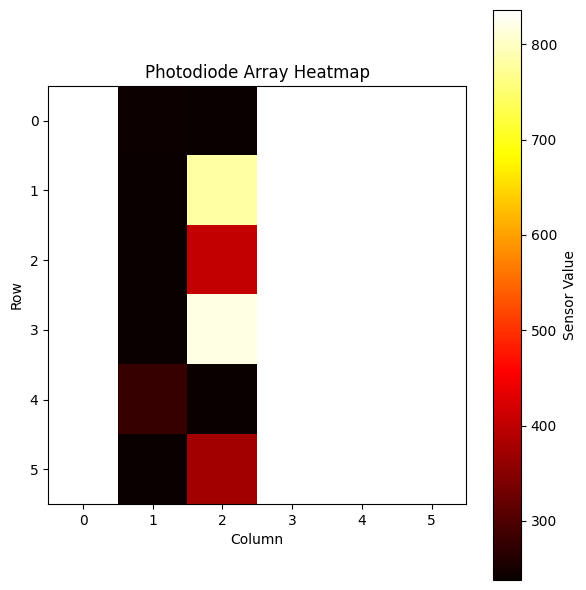

[0.9983277591973244, 0.006688963210702341, 0.0, 0.9983277591973244, 0.9983277591973244, 1.0, 0.9983277591973244, 0.0016722408026755853, 0.9096989966555183, 0.9983277591973244, 0.9983277591973244, 1.0, 0.9983277591973244, 0.0016722408026755853, 0.27591973244147155, 0.9983277591973244, 0.9983277591973244, 1.0, 0.9983277591973244, 0.0016722408026755853, 0.9698996655518395, 0.9983277591973244, 1.0, 1.0, 0.9983277591973244, 0.07023411371237458, 0.0016722408026755853, 0.9983277591973244, 1.0, 1.0, 0.9983277591973244, 0.0016722408026755853, 0.22909698996655517, 0.9983277591973244, 0.9983277591973244, 1.0]


In [104]:
import serial
import time
import matplotlib.pyplot as plt
import numpy as np

ser = serial.Serial('/dev/cu.usbmodem11301', 115200)
time.sleep(2) 

ser.write(b'START\n')
matrix = []

while len(matrix) < 36:
    line = ser.readline().decode().strip()
    # print(f"rec: {line}")
    try:
        values = list(map(int, line.split()))
        matrix.extend(values)
        # print(matrix)
    except ValueError:
        print(f"cant parse '{line}'")
ser.close()
matrix = np.array(matrix).reshape((6, 6))

plt.figure(figsize=(6, 6))
plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Sensor Value')
plt.title("Photodiode Array Heatmap")
plt.xlabel("Column")
plt.ylabel("Row")
plt.tight_layout()
plt.show()

normalized_matrix = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
flat_list = normalized_matrix.flatten().tolist()

print(flat_list)

            

In [105]:
agh = np.array(flat_list)

In [106]:
predict(agh)

' 2'

In [ ]:
training = False
label = 2
if training:
    with open('handgesture.txt', 'a') as f:
        f.write(', '.join(map(str, flat_list)))
        f.write(f', {label}\n') 

            